In [101]:
%pip install girder_client

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/pip/__main__.py", line 8, in <module>
    if sys.path[0] in ("", os.getcwd()):
                           ^^^^^^^^^^^
PermissionError: [Errno 1] Operation not permitted
Note: you may need to restart the kernel to use updated packages.


In [102]:
from girder_client import GirderClient
client = GirderClient(apiUrl="https://data.imqcam.org/api/v1")
client.authenticate(apiKey='ZWsKLbWmokMjJeE6Ihz7Zve74rZWiJLHyAALBNGB')
result = client.get("entry", parameters={"formId": "67d39472366ec49ab59dd4db", "limit": 10000})

KeyboardInterrupt: 

In [ ]:
len(result)

201

In [ ]:
import pandas as pd

In [ ]:
df_org = pd.DataFrame([result[i]['data'] for i in range(len(result))])
df_org.head()

,Build_Date,Build_ID,DOE_Code,DOE_ID,Elongation_Percent,Hatch_mm,Layer_mm,Modulus_GPa,Orientation,Parameter_Label,Peak_Stress_MPa,Percent_Porosity_Contour,Porosity_percent_infill,Power_W,Specimen_Position,Speed_mm_per_s,Total_Porosity_Percent,VED_J_per_mm3,Yield_Strength_MPa
0,2022-01-01,A01_2022-01-01_JHUAPL_EOSM290_Ti64_Cylinder,1,A,7.329018,0.14,0.03,82.95913,Horizontal,A01,1047.749,0.010968,0.312183,160,Baseplate,1200,0.245827,31.746032,877.2680
1,2022-01-01,A02_2022-01-01_JHUAPL_EOSM290_Ti64_Cylinder,1,A,6.279538,0.14,0.03,83.17367,Horizontal,A02,1098.062,0.000000,0.026001,180,Baseplate,1200,0.020268,35.714286,974.6752
2,2022-01-01,A03_2022-01-01_JHUAPL_EOSM290_Ti64_Cylinder,1,A,12.403910,0.14,0.03,100.26750,Horizontal,A03,1135.778,0.000424,0.003644,200,Baseplate,1200,0.002859,39.682540,950.5035
3,2022-01-01,A04_2022-01-01_JHUAPL_EOSM290_Ti64_Cylinder,1,A,8.149077,0.14,0.03,93.70417,Horizontal,A04,1128.017,0.000000,0.002252,220,Baseplate,1200,0.001640,43.650794,986.5347
4,2022-01-01,A05_2022-01-01_JHUAPL_EOSM290_Ti64_Cylinder,1,A,10.102670,0.14,0.03,99.61740,Horizontal,A05,1138.589,0.000614,0.001353,240,Baseplate,1200,0.001109,47.619048,974.6122


In [ ]:
#df.to_csv('imqcam.csv', index=False)

In [ ]:
df_org[df_org['Build_ID']=='C50_2022-01-11_JHUAPL_EOSM290_Ti64_Cylinder']

,Build_Date,Build_ID,DOE_Code,DOE_ID,Elongation_Percent,Hatch_mm,Layer_mm,Modulus_GPa,Orientation,Parameter_Label,Peak_Stress_MPa,Percent_Porosity_Contour,Porosity_percent_infill,Power_W,Specimen_Position,Speed_mm_per_s,Total_Porosity_Percent,VED_J_per_mm3,Yield_Strength_MPa
200,2022-01-11,C50_2022-01-11_JHUAPL_EOSM290_Ti64_Cylinder,3,C,9.680027,0.18,0.03,101.81277,Horizontal,C50,1194.572971,-1.0,0.046283,141,Baseplate,486,-1.0,53.726566,1044.798526


In [226]:
df_org.rename(columns={'Elongation_Percent': 'Elongation',"Yield_Strength_MPa": "Yield_Str", "DOE_Code": "DOE_ID", "DOE_ID" : "DOE_Code"},inplace=True)
df=df_org.copy()
df = df[(df.Elongation>0) & (df.Yield_Str>910) & (df.Porosity_percent_infill < 0.1) & (df.Porosity_percent_infill > 0) ]
df.shape
#df.Total_Porosity_Percent.value_counts()
num=0

In [248]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull
import numpy as np
from ipywidgets import interact, widgets

df=df_org.copy()
num = num+0.1
df = df[(df.Elongation>0) & (df.Yield_Str>0) & (df.Porosity_percent_infill < 0.1) ]
#df = df[df.Porosity_percent_infill < 0.1 ]


# Dropdown widget: x axis
x_dropdown = widgets.Dropdown(
    options=list(df.columns),
    value="Elongation",#None,
    description='Select X Axis:',
    disabled=False,
)
# Dropdown widget: y axis
y_dropdown = widgets.Dropdown(
    value="Yield_Str",#None,
    options=list(df.columns),
    #value=1,
    description='Select Y Axis:',
    disabled=False,
)
# dropdown to select hue
hue_dropdown = widgets.Dropdown(
    options=list(df.columns),
    value="DOE_ID",#None,
    description='Select Hue:',
    disabled=False,
)
submit_button = widgets.Button(
    description='Submit',
    button_style='success'  # 'primary', 'success', 'info', 'warning', 'danger'
)


def get_plot(x,y, hue=None):
    if x is None or y is None or hue is None:
        print("Please select valid x, y, and hue values.")
        return
    else:
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")
        # Create scatter plot
        palette = sns.color_palette('bright'        , as_cmap=False, n_colors=len(hue)+1)
        sns.scatterplot(
            data=df,
            x=x,
            y=y,
            hue=hue,
            palette=palette,
            s=40,
            edgecolor='black',
            linewidth=0.5
        )
        # Draw convex hulls for each DOE_ID

        for key, group in df.groupby(hue):
            if len(group) >= 3:  # Need at least 3 points for a hull
                points = group[[x, y]].values
                hull = ConvexHull(points)
                hull_points = points[hull.vertices]
                plt.fill(hull_points[:, 0], hull_points[:, 1], alpha=0.2, 
                        #label=f"Group {key}", 
                        edgecolor='black')

        # Annotate specific points (optional: based on criteria or fixed list)
        # highlight_samples = ['A06', 'B84', 'B41', 'A51 (Stock)', 'B38', 'A03', 'A01', 'B35']
        # highlighted = df[df[hue].isin(highlight_samples)]
        # for _, row in highlighted.iterrows():
        #     plt.text(row[x] + 0.2, row[y], row[hue], fontsize=9)

        plt.xlabel(x)
        plt.ylabel(y)
        #plt.ylim(800,1200)
        plt.title(f'{x} vs {y} by {hue}')
        plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
try:
    interact(get_plot, x=x_dropdown, y=y_dropdown, hue=hue_dropdown)
except Exception as e:
    print(f"An error occurred: {e}")
# Interactive connection

interactive(children=(Dropdown(description='Select X Axis:', index=4, options=('Build_Date', 'Build_ID', 'DOE_…

In [223]:
num

3.1000000000000014

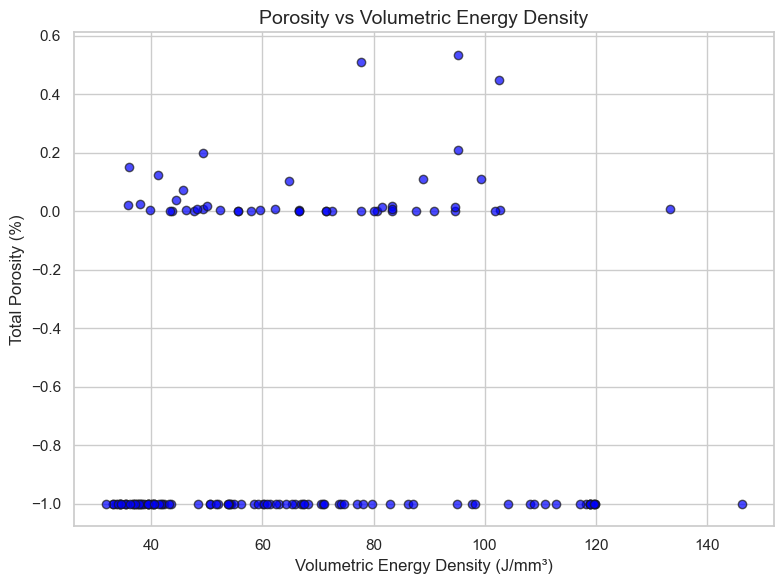

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
# df = pd.read_csv('your_file.csv')  # if from CSV
# or df = your existing DataFrame

# Plotting Total Porosity (%) vs VED (J/mm³)
plt.figure(figsize=(8, 6))
plt.scatter(df['VED_J_per_mm3'], df['Total_Porosity_Percent'], alpha=0.7, c='blue', edgecolors='k')

plt.xlabel('Volumetric Energy Density (J/mm³)', fontsize=12)
plt.ylabel('Total Porosity (%)', fontsize=12)
plt.title('Porosity vs Volumetric Energy Density', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [104]:
df_org

,Build_Date,Build_ID,DOE_Code,DOE_ID,Elongation,Hatch_mm,Layer_mm,Modulus_GPa,Orientation,Parameter_Label,Peak_Stress_MPa,Percent_Porosity_Contour,Porosity_percent_infill,Power_W,Specimen_Position,Speed_mm_per_s,Total_Porosity_Percent,VED_J_per_mm3,Yield_Str
0,2022-01-01,A01_2022-01-01_JHUAPL_EOSM290_Ti64_Cylinder,1,A,7.329018,0.14,0.03,82.959130,Horizontal,A01,1047.749000,0.010968,0.312183,160,Baseplate,1200,0.245827,31.746032,877.268000
1,2022-01-01,A02_2022-01-01_JHUAPL_EOSM290_Ti64_Cylinder,1,A,6.279538,0.14,0.03,83.173670,Horizontal,A02,1098.062000,0.000000,0.026001,180,Baseplate,1200,0.020268,35.714286,974.675200
2,2022-01-01,A03_2022-01-01_JHUAPL_EOSM290_Ti64_Cylinder,1,A,12.403910,0.14,0.03,100.267500,Horizontal,A03,1135.778000,0.000424,0.003644,200,Baseplate,1200,0.002859,39.682540,950.503500
3,2022-01-01,A04_2022-01-01_JHUAPL_EOSM290_Ti64_Cylinder,1,A,8.149077,0.14,0.03,93.704170,Horizontal,A04,1128.017000,0.000000,0.002252,220,Baseplate,1200,0.001640,43.650794,986.534700
4,2022-01-01,A05_2022-01-01_JHUAPL_EOSM290_Ti64_Cylinder,1,A,10.102670,0.14,0.03,99.617400,Horizontal,A05,1138.589000,0.000614,0.001353,240,Baseplate,1200,0.001109,47.619048,974.612200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,2022-01-11,C46_2022-01-11_JHUAPL_EOSM290_Ti64_Cylinder,3,C,5.814006,0.11,0.03,91.659481,Horizontal,C46,1096.072488,-1.000000,0.883416,277,Baseplate,2641,-1.000000,31.783186,928.953323
197,2022-01-11,C47_2022-01-11_JHUAPL_EOSM290_Ti64_Cylinder,3,C,12.634981,0.09,0.03,93.334590,Horizontal,C47,1127.370889,-1.000000,0.167868,62,Baseplate,444,-1.000000,51.718385,946.476835
198,2022-01-11,C48_2022-01-11_JHUAPL_EOSM290_Ti64_Cylinder,3,C,-1.000000,0.05,0.03,-1.000000,Horizontal,C48,-1.000000,-1.000000,1.292320,106,Baseplate,1736,-1.000000,40.706605,-1.000000
199,2022-01-11,C49_2022-01-11_JHUAPL_EOSM290_Ti64_Cylinder,3,C,-1.000000,0.11,0.03,-1.000000,Horizontal,C49,-1.000000,-1.000000,2.422880,60,Baseplate,539,-1.000000,33.732501,-1.000000


/var/folders/zv/zjfn5vt901z0rpwtygdc5hyc0000gn/T/ipykernel_10581/4002371859.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend


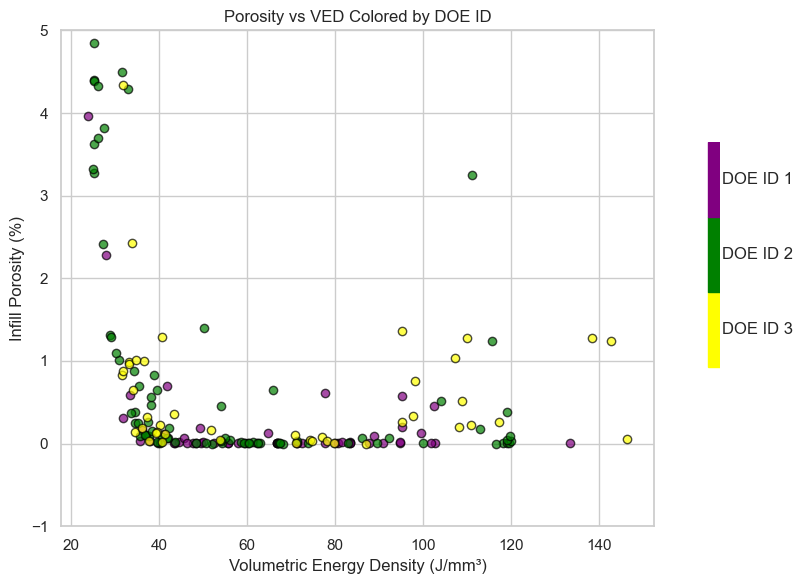

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Color mapping
color_map = {
    1: 'purple',
    2: 'green',
    3: 'Yellow'
}

# Create main plot
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot colored by DOE_ID
for doe_id, color in color_map.items():
    subset = df_org[(df_org['DOE_Code'] == doe_id) & (df_org['Porosity_percent_infill'] > 0)]
    ax.scatter(
        subset['VED_J_per_mm3'],
        subset['Porosity_percent_infill'],
        color=color,
        edgecolors='black',
        alpha=0.7
    )

# Axis labels and title
ax.set_xlabel('Volumetric Energy Density (J/mm³)')
ax.set_ylabel('Infill Porosity (%)')
ax.set_title('Porosity vs VED Colored by DOE ID')

# # Set axis ranges
# ax.set_xlim(0, 150)
ax.set_ylim(-1, 5)

# Create a new inset axes on the right for vertical color bar
bar_ax = fig.add_axes([0.88, 0.25, 0.03, 0.5])  # [left, bottom, width, height]

# Create vertical patches for DOE_IDs
for i, (doe_id, color) in enumerate(reversed(color_map.items())):
    bar_ax.add_patch(
        mpatches.Rectangle((0, i), 1, 1, color=color)
    )
    bar_ax.text(1.2, i + 0.5, f'DOE ID {doe_id}', va='center')

bar_ax.set_xlim(-1, 1)
bar_ax.set_ylim(-1, len(color_map))
bar_ax.axis('off')

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend
plt.show()


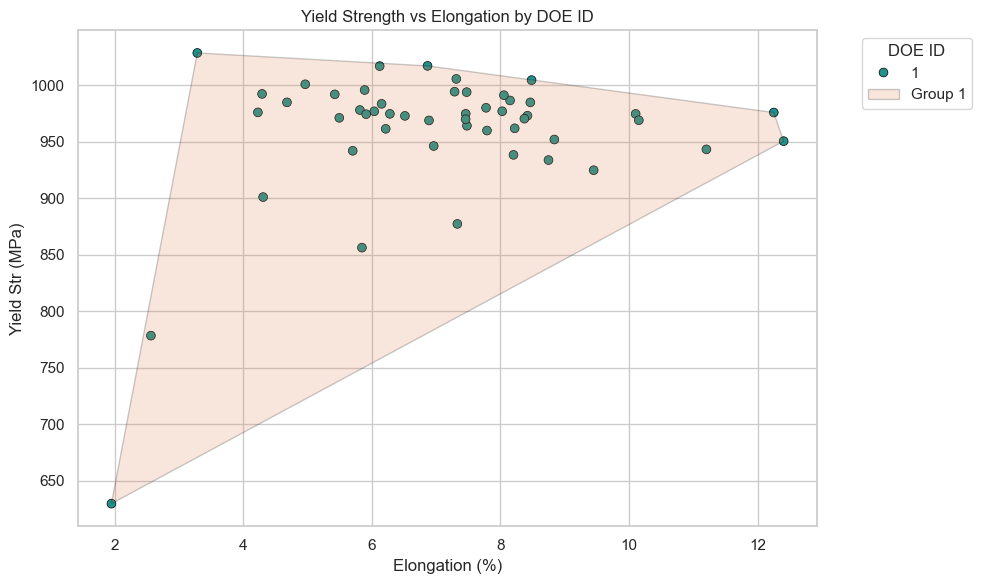

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull
import numpy as np

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create scatter plot
palette = sns.color_palette("viridis", as_cmap=False, n_colors=df['DOE_ID'].nunique())
sns.scatterplot(
    data=df,
    x='Elongation',
    y='Yield_Str',
    hue='DOE_ID',
    palette=palette,
    s=40,
    edgecolor='black',
    linewidth=0.5
)

# Draw convex hulls for each DOE_ID
for key, group in df.groupby('DOE_ID'):
    if len(group) >= 3:  # Need at least 3 points for a hull
        points = group[['Elongation', 'Yield_Str']].values
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        plt.fill(hull_points[:, 0], hull_points[:, 1], alpha=0.2, label=f"Group {key}", edgecolor='black')

# Annotate specific points (optional: based on criteria or fixed list)
highlight_samples = ['A06', 'B84', 'B41', 'A51 (Stock)', 'B38', 'A03', 'A01', 'B35']
highlighted = df[df['DOE_ID'].isin(highlight_samples)]
for _, row in highlighted.iterrows():
    plt.text(row['Elongation'] + 0.2, row['Yield_Str'], row['Label'], fontsize=9)

plt.xlabel('Elongation (%)')
plt.ylabel('Yield Str (MPa)')
plt.title('Yield Strength vs Elongation by DOE ID')
plt.legend(title='DOE ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
